In [1]:
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape

BATCH_SIZE = 64


In [2]:
def process_image(image):
    image = tf.cast(image, tf.float32)/255
    return image, image
    # maybe add augmentation + hue, saturation, greyscale and so on

In [3]:
training_dataset = image_dataset_from_directory(
    "/Projects/coursework/Flicker8k_dataset/Flicker8k_images/",
    labels=None,
    image_size=(224,224),
    batch_size=BATCH_SIZE,
    subset='training',
    validation_split=0.1, 
    seed=17
)

validation_dataset = image_dataset_from_directory(
    "/Projects/coursework/Flicker8k_dataset/Flicker8k_images/",
    labels=None,
    image_size=(224,224),
    batch_size=BATCH_SIZE,
    subset='validation',
    validation_split=0.1,
    seed=17
)

training_dataset = training_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset = training_dataset.shuffle(buffer_size=1000)
training_dataset = training_dataset.prefetch(tf.data.AUTOTUNE)

validation_dataset = validation_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

Found 8091 files belonging to 1 classes.
Using 7282 files for training.
Found 8091 files belonging to 1 classes.
Using 809 files for validation.


In [4]:
STEPS = len(training_dataset)
VAL_STEPS = len(validation_dataset)

# Model

In [ ]:
# Encoder layers
encoder_input = Input(shape=(224, 224, 3))
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder_ouput = Flatten()(x)

encoder = Model(encoder_input, encoder_ouput, name = 'encoder')

encoder.summary()

reshape_target = encoder.layers[-2].output.shape[1:]
input_shape = shape=encoder.output[0].shape

# Decoder layers
decoder_input = Input(input_shape)
dec_reshape = Reshape(reshape_target)(decoder_input) 
x = Conv2D(8, (3, 3), activation='relu', padding='same')(dec_reshape)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoder_ouput = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoder_ouput, name = 'decoder')

decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1568)]            0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 8)        0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 56, 56, 8)        0         
 2D)                                                       

In [7]:
input = Input(shape=(224,224,3))
encoder_output = encoder(input)
decoder_output = decoder(encoder_output)

autoencoder = Model(input, decoder_output, name='autoencoder')

autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder (Functional)        (None, 1568)              26624     
                                                                 
 decoder (Functional)        (None, 224, 224, 3)       27203     
                                                                 
Total params: 53,827
Trainable params: 53,827
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
early_stopping = EarlyStopping(patience=4, verbose= 1)

training = autoencoder.fit(
    training_dataset,
    epochs=100,
    steps_per_epoch=STEPS,
    validation_data=validation_dataset,
    validation_steps=VAL_STEPS,
    callbacks=[early_stopping],
    verbose=1
)

encoder.save('models/convolution_autoencoder.keras')

Epoch 1/100
114/114 [==============================] - 35s 192ms/step - loss: 0.0395 - val_loss: 0.0277
Epoch 2/100
114/114 [==============================] - 21s 159ms/step - loss: 0.0258 - val_loss: 0.0248
Epoch 3/100
114/114 [==============================] - 21s 158ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 4/100
114/114 [==============================] - 21s 160ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 5/100
114/114 [==============================] - 20s 153ms/step - loss: 0.0207 - val_loss: 0.0219
Epoch 6/100
114/114 [==============================] - 21s 153ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 7/100
114/114 [==============================] - 21s 155ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 8/100
114/114 [==============================] - 21s 156ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/100
114/114 [==============================] - 21s 158ms/step - loss: 0.0173 - val_loss: 0.0176
Epoch 10/100
114/114 [==============================] - 21s 158m

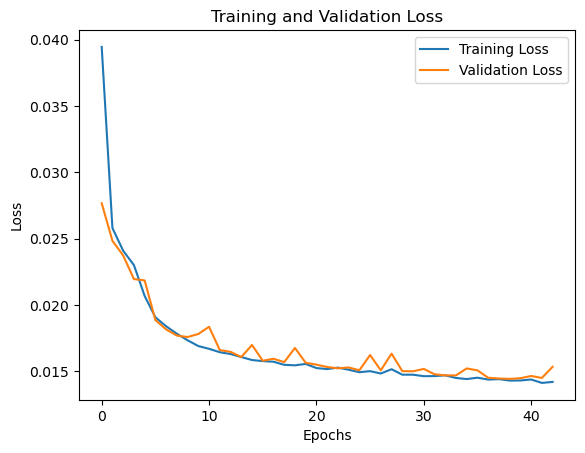

In [9]:
# plt.figure(figsize=(10, 6))
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

1/1 [==============================] - 0s 17ms/step


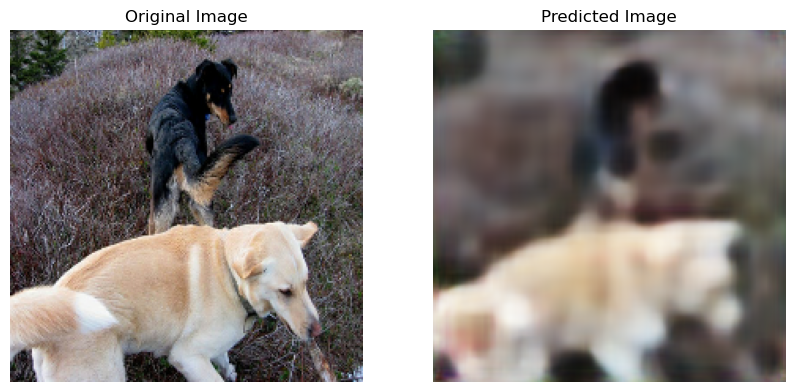

In [13]:
test_dataset = training_dataset.take(1)

for batch in test_dataset:
    test_image = batch[0][0]

plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)  
plt.imshow(test_image)
plt.title("Original Image")
plt.axis('off')  

test_image = tf.expand_dims(test_image, axis=0)
prediction = autoencoder.predict(test_image)

# Predicted Image
plt.subplot(1, 2, 2)  
plt.imshow(prediction[0])
plt.title("Predicted Image")
plt.axis('off')  


plt.show()